# 3rd go: using GP to model CCF and compute derivatives

Suzanne Aigrain @ Oxford, June 2019

In [2]:
%pylab inline
import pickle
from george import kernels, GP
from scipy.optimize import minimize
import emcee
import corner

Populating the interactive namespace from numpy and matplotlib


Read in CCFs from 2018 and select very quiet period when the Jupiter RV signal is approx constant to construct CCF reference.

In [3]:
year = '2018'
with open('ccf_'+year,'rb') as infile:
    ccfYear = pickle.load(infile)
nobs,nvel = np.shape(ccfYear)
crval1 = -20
cdelt1 = 0.25
vel = np.arange(nvel)*cdelt1 + crval1

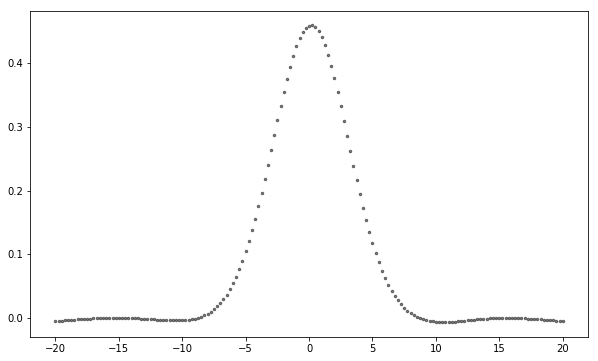

In [16]:
y = 1-np.mean(ccfYear[125:150,:],axis=0)
#y = 0.45 * np.exp(-(vel)**2/3.0**2/2.0)
#y = np.sin(vel)
sig=0.00001
#y += sig * np.random.normal(size=len(vel))
y = 1-ccfYear[130,:].flatten()
plt.figure(figsize=(10,6))
plt.plot(vel,y,'k.',ms=5,alpha=0.5)


Model the CCF using a squared exponential GP

[  0.08271407 -11.51292546   0.           2.30258509]
[1.08623118e+00 1.00000000e-05 1.00000000e+00 1.00000000e+01]
[1.06302956e+00 5.10960813e-10 9.27067765e-02 1.30892235e+01]


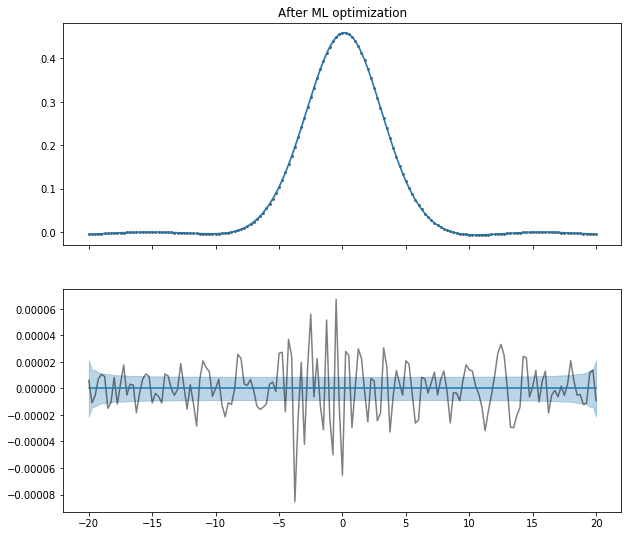

In [17]:
k = 1.0 * kernels.ExpSquaredKernel(10.0)
gp = GP(k,mean=np.mean(y), fit_mean=True, white_noise = np.log(sig), fit_white_noise=True)
print(gp.get_parameter_vector())
def nllGP(p,x,y):
    if (abs(p[2:])>10).any():
        return 1e25        
    gp.set_parameter_vector(p)
    try:
        gp.compute(x)
    except:
        return 1e25
    return -gp.lnlikelihood(y, quiet=True)
def lnprobGP(p,x,y):
    return -nllGP(p,x,y)
p0 = gp.get_parameter_vector()
print(np.exp(p0))
soln = minimize(nllGP,p0,args=(vel,y))
p1 = soln.x
print(np.exp(p1))
gp.set_parameter_vector(p1)
mu, var = gp.predict(y, vel, return_var=True)
std = np.sqrt(var)
fig,axes = plt.subplots(2,1,figsize=(10,9),sharex = True)
axes[0].set_title('After ML optimization')
axes[0].plot(vel,y, 'k.', ms = 4, alpha = 0.5)
axes[0].plot(vel,mu)
axes[0].fill_between(vel,mu+std,mu-std,alpha=0.3,color='C0')
axes[1].plot(vel,y-mu, 'k-', ms = 4, alpha = 0.5)
axes[1].plot(vel,mu-mu)
axes[1].fill_between(vel,std,-std,alpha=0.3,color='C0')

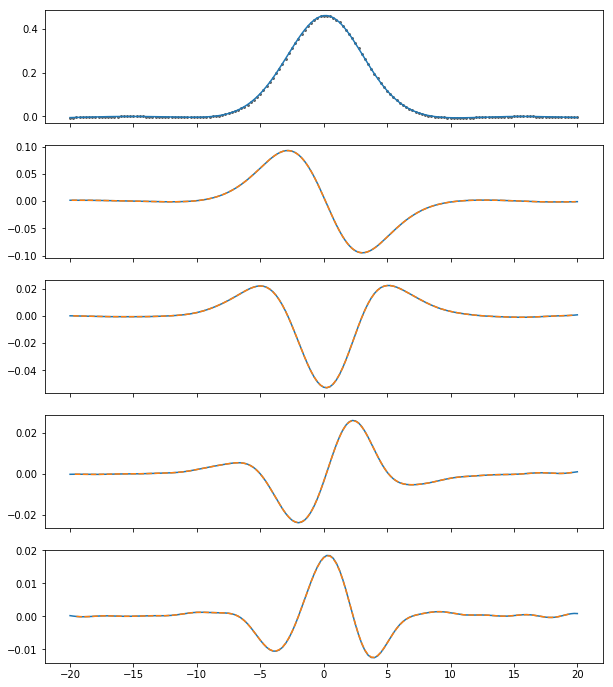

In [18]:
newp = k.get_parameter_vector()
newp[1] = np.exp(newp[1])
gp.set_parameter('mean:value',0.0)
mu = gp.predict(y,vel,return_var=False,return_cov=False)

kp = 1.0 * kernels.ExpSquaredPrimeKernel(10.0)
kp.set_parameter_vector(newp)
mup = gp.predict(y,vel,kernel=kp,return_var=False,return_cov=False)
dv = vel[1]-vel[0]
mup2 = (mu[1:]-mu[:-1])/dv

kpp = 1.0 * kernels.ExpSquaredDoublePrimeKernel(10.0)
kpp.set_parameter_vector(newp)
mupp = gp.predict(y,vel,kernel=kpp,return_var=False,return_cov=False)
mupp2 = (mup2[1:]-mup2[:-1])/dv

kppp = 1.0 * kernels.ExpSquaredTriplePrimeKernel(10.0)
kppp.set_parameter_vector(newp)
muppp = gp.predict(y,vel,kernel=kppp,return_var=False,return_cov=False)
muppp2 = (mupp2[1:]-mupp2[:-1])/dv

kpppp = 1.0 * kernels.ExpSquaredQuadruplePrimeKernel(10.0)
kpppp.set_parameter_vector(newp)
mupppp = gp.predict(y,vel,kernel=kpppp,return_var=False,return_cov=False)
mupppp2 = (muppp2[1:]-muppp2[:-1])/dv

fig,axes = plt.subplots(5,1,figsize=(10,12),sharex = True)
axes[0].plot(vel,y, 'k.', ms = 4, alpha = 0.5)
axes[0].plot(vel,mu,'C0-')
axes[1].plot(vel,mup, 'C0-')
axes[1].plot(vel[:-1]+0.5*dv,mup2, 'C1--')
axes[2].plot(vel,mupp, 'C0-')
axes[2].plot(vel[1:-1],mupp2, 'C1--')
axes[3].plot(vel,muppp, 'C0-')
axes[3].plot(vel[1:-2]+0.5*dv,muppp2, 'C1--')
axes[4].plot(vel,mupppp, 'C0-')
axes[4].plot(vel[2:-2],mupppp2, 'C1--')


Now read 2017 CCFs (slightly more active)

In [19]:
year = '2015'
with open('ccf_'+year,'rb') as infile:
    ccfYear = pickle.load(infile)
nobs,nvel = np.shape(ccfYear)

Unpack BJD, average daily heliocentric RVs corrected for bad weather and differential extinction, and solar barycentric velocity.

In [20]:
with open('vel_'+year,'rb') as infile:
    velYear = pickle.load(infile)

bjd = velYear[:,0]
rvh = velYear[:,1]
bsrv = velYear[:,2]
rvb = rvh - bsrv

Display residual CCF timeseries.

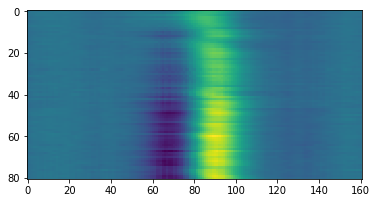

In [21]:
plt.imshow(ccfYear + y)

Plot average daily heliocentric RVs corrected for bad weather and differential extinction.

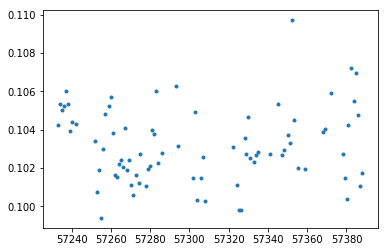

In [22]:
plt.plot(bjd,rvh,'.')

Plot average daily barycentric RVs corrected for bad weather and differential extinction.

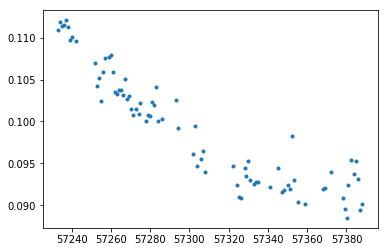

In [23]:
plt.plot(bjd,rvb,'.')

In [ ]:
d0 = ccfRef
dmin,dmax = d0.min(),d0.max()
x1 = (d0-dmin)/(dmax-dmin)
d0p = np.append(d0[1:]-d0[:-1],0)
dmin,dmax = d0p.min(),d0p.max()
x2 = (d0p-dmin)/(dmax-dmin)
d0pp = np.append(0,d0p[1:]-d0p[:-1])
dmin,dmax = d0pp.min(),d0pp.max()
x3 = (d0pp-dmin)/(dmax-dmin)

In [ ]:
from scipy.optimize import minimize
p1 = np.zeros((len(bjd),4))
ccfMod = np.zeros_like(ccfYear)
ccfMod1 = np.zeros_like(ccfYear)
ccfMod2 = np.zeros_like(ccfYear)
coeffs = np.zeros((len(bjd),4))
for i in range(len(bjd)):
    d = ccfYear[i,:].flatten()
    y = d - d0
    def model(p):
        m = p[0] + p[1] * x1 + p[2] * x2 + p[3] * x3
        return m
    def nll(p,y):
        m = model(p)
        return ((y-m)**2).sum()
    p0 = np.zeros(4)
    soln = minimize(nll,p0,args=(y))
    p1[i,:] = soln.x
    ccfMod[i,:] = model(soln.x)
    pp = np.copy(soln.x)
    pp[0] = 0
    pp[2] = 0
    ccfMod1[i,:] = model(pp)
    pp = np.copy(soln.x)
    pp[1] = 0
    pp[3] = 0
    ccfMod2[i,:] = model(pp)

In [ ]:
fig,axes=plt.subplots(1,4,sharex=True,figsize = (16,4))
axes[0].imshow(ccfYear - ccfRef)
axes[1].imshow(ccfMod)
axes[2].imshow(ccfMod1)
axes[3].imshow(ccfMod2)
axes[0].xaxis.set_visible(False) 
axes[0].yaxis.set_visible(False) 
axes[1].xaxis.set_visible(False) 
axes[1].yaxis.set_visible(False) 
axes[2].xaxis.set_visible(False) 
axes[2].yaxis.set_visible(False) 
axes[3].xaxis.set_visible(False) 
axes[3].yaxis.set_visible(False) 
axes[0].set_title('observed residuals')
axes[1].set_title('modelled residuals')
axes[2].set_title('non-Doppler only')
axes[3].set_title('Doppler only')
plt.savefig('diff_ccf.png')

In [ ]:
fig,axes=plt.subplots(2,3,sharex=True,figsize = (12,8))
rvpl = rvb-rvh
axes[0,0].plot(bjd,rvpl,'.')
axes[0,1].plot(bjd,p1[:,0].flatten(),'.')
axes[0,2].plot(bjd,p1[:,1].flatten(),'.')
axes[1,0].plot(bjd,p1[:,2].flatten(),'.')
axes[1,1].plot(bjd,p1[:,3].flatten(),'.')
